In [2]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType

feats = []
f = open('../features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

In [3]:
%%time

df = spark.read.format('csv').option('sep', '\t').schema(schema).load('hdfs://orion11:30999/nam/data/nam_s')
df.take(1)

CPU times: user 77.4 ms, sys: 36.9 ms, total: 114 ms
Wall time: 5min 24s


## Finding Featueres

For this part of the project we want to be able predict vegitation surface based on a certain number a features.
Initially we chose features with a higher Pearson Correlation Coeffient to decide which features to include and include ALL of them. However this in the end lead to a very high RMSE Since we had way to many features included (RMSE for our first attempt was almost 40%) For the following we trimmed the features down to slightly less and got some slight improvement.

For the trial below we used "direct_evaporation_cease_soil_moisture_surface", "precipitable_water_entire_atmosphere", "soil_porosity_surface", "direct_evaporation_cease_soil_moisture_surface".
Mostly features that relate to the soil in the ground.

In [5]:
from pyspark.ml.feature import VectorAssembler

def prepare_data(dframe, predictors, target):
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    output = assembler.transform(dframe)
    return output.select("features", target).withColumnRenamed(target, "label")

In [3]:


prepped = prepare_data(df,
    [ "direct_evaporation_cease_soil_moisture_surface", 
         "precipitable_water_entire_atmosphere", 
         "soil_porosity_surface",
        "direct_evaporation_cease_soil_moisture_surface"],
    "vegetation_surface")

prepped.show()
(trainingData, testData) = prepped.randomSplit([0.9, 0.1])

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.06624999642372...|95.75|
|(4,[1],[20.392850...|  0.0|
|[0.02749999985098...|86.25|
|(4,[1],[55.483531...|  0.0|
|[0.04749999940395...|41.25|
|(4,[1],[27.725078...|  0.0|
|[0.13499999046325...| 64.5|
|(4,[1],[17.061397...|  0.0|
|(4,[1],[23.348155...|  0.0|
|(4,[1],[53.529350...|  0.0|
|(4,[1],[39.825428...|  0.0|
|(4,[1],[26.067039...|  0.0|
|[0.04749999940395...| 77.0|
|(4,[1],[26.277297...|  0.0|
|(4,[1],[25.827457...|  0.0|
|[0.06624999642372...|43.25|
|[0.06624999642372...| 58.0|
|(4,[1],[53.584957...|  0.0|
|(4,[1],[53.376407...|  0.0|
|(4,[1],[54.270172...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [4]:
%%time 
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(numTrees=100, maxDepth=5, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 14.0523
CPU times: user 411 ms, sys: 188 ms, total: 599 ms
Wall time: 36min 4s


As Shown above this did not produce an accruate model at all. Perhaps we need to trim the features even more.


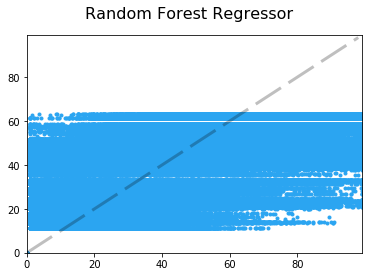

In [7]:
import matplotlib.pyplot as plt
pdf = predictions.sample(False, 0.1)
p_df = pdf.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()

## MORE TRIMMING

For here we will remove some of the soil features and add in rainfall as a feature to measure



In [8]:
prepped = prepare_data(df,
    [  "precipitable_water_entire_atmosphere", 
         "soil_porosity_surface",
        "categorical_rain_yes1_no0_surface"
],
    "vegetation_surface")

prepped.show()
(trainingData, testData) = prepped.randomSplit([0.9, 0.1])

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[24.3113269805908...|95.75|
|[20.3928508758544...|  0.0|
|[23.4750785827636...|86.25|
|[55.4835319519043...|  0.0|
|[17.9072780609130...|41.25|
|[27.7250785827636...|  0.0|
|[48.6899909973144...| 64.5|
|[17.0613975524902...|  0.0|
|[23.3481559753417...|  0.0|
|[53.5293502807617...|  0.0|
|[39.8254280090332...|  0.0|
|[26.0670394897460...|  0.0|
|[45.5307846069335...| 77.0|
|[26.2772979736328...|  0.0|
|[25.8274574279785...|  0.0|
|[19.0562362670898...|43.25|
|[29.5487270355224...| 58.0|
|[53.5849571228027...|  0.0|
|[53.3764076232910...|  0.0|
|[54.2701721191406...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [9]:
%%time 
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(numTrees=100, maxDepth=5, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 16.4057
CPU times: user 498 ms, sys: 252 ms, total: 750 ms
Wall time: 47min 9s


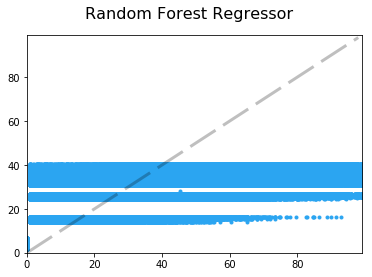

In [10]:
import matplotlib.pyplot as plt
pdf = predictions.sample(False, 0.1)
p_df = pdf.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()

Not much better. When looking into the pearson correlations there does not seem like there is a feature that is nessessarily correlated with vegetation. For Now we can attempt to predict a different feature with more correlated features...


In [6]:
prepped = prepare_data(df,
    [  "transpiration_stress-onset_soil_moisture_surface", 
         "land_cover_land1_sea0_surface",
        "soil_porosity_surface",
         "wilting_point_surface"
],
    "number_of_soil_layers_in_root_zone_surface")

prepped.show()
(trainingData, testData) = prepped.randomSplit([0.9, 0.1])

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.32999998331069...|  4.0|
|           (4,[],[])|  0.0|
|[0.28249999880790...|  4.0|
|           (4,[],[])|  0.0|
|[0.3125,1.0,0.5,0...|  4.0|
|           (4,[],[])|  0.0|
|[0.40250000357627...|  3.0|
|           (4,[],[])|  0.0|
|           (4,[],[])|  0.0|
|           (4,[],[])|  0.0|
|           (4,[],[])|  0.0|
|           (4,[],[])|  0.0|
|[0.3125,1.0,0.5,0...|  4.0|
|           (4,[],[])|  0.0|
|           (4,[],[])|  0.0|
|[0.32999998331069...|  3.0|
|[0.32999998331069...|  4.0|
|           (4,[],[])|  0.0|
|           (4,[],[])|  0.0|
|           (4,[],[])|  0.0|
+--------------------+-----+
only showing top 20 rows



In [7]:
%%time 
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(numTrees=100, maxDepth=5, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.358309
CPU times: user 391 ms, sys: 162 ms, total: 552 ms
Wall time: 28min 19s


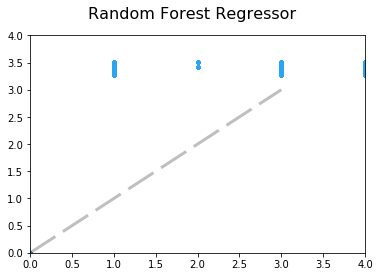

In [9]:
import matplotlib.pyplot as plt
pdf = predictions.sample(False, 0.1)
p_df = pdf.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()